In [252]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.25)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

## MSM of a bistable model potential
Here we analyze a Brownian dynamics trajectory on the model potential by Berezhkovskii et al ([*J. Chem. Phys.*, 2014](https://doi.org/10.1063/1.4902243)), used in the context of single molecule force spectroscopy by Cossio, Hummer and Szabo ([*PNAS*, 2015](https://doi.org/10.1073/pnas.1519633112)).

### Analysis

First of all, we import the [PyEMMA](www.emma-project.org) software package.

In [253]:
import pyemma
pyemma.__version__

'2.5.7'

Next we load a trajectory run on the bistable potential and check for the shape of the trajectory.

In [254]:
h5file = "./data/cossio_kl1.3_Dx1_Dq1.h5"
f = h5py.File(h5file, 'r')
data0 = np.array(f['data'])
f.close()
X = data0[:,[1,2]]

In [255]:
X0, X1 = X[:,0], X[:,1]
X.shape, X0.shape, X1.shape

((25001, 2), (25001,), (25001,))

In [256]:
from pyemma.util.contexts import settings
import pyemma.coordinates as coor
import pyemma.plots as mplt

Check $x$ and $y$ coordinates along the trajectory. We see that as we would expect for this model both coordinates are highly correlated.

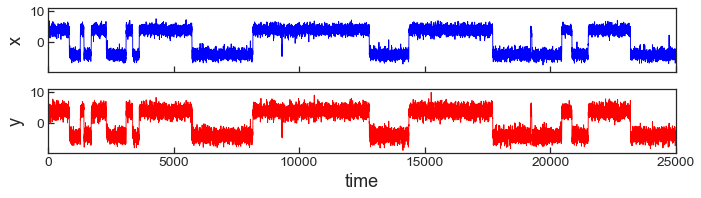

In [257]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10, 3.))
ax[0].plot(range(len(X[:,0])), X[:,0], linewidth=0.9, c='blue')
ax[1].plot(range(len(X[:,1])), X[:,1], linewidth=0.9, c='red')
ax[1].set_xlabel('time', fontsize=18)
ax[0].set_ylabel('x', fontsize=18)
ax[1].set_ylabel('y', fontsize=18)
ax[0].set_xlim(0, 25000)
plt.tight_layout()
plt.savefig('../figures/cossio/traj_1d.png', dpi=300, transparent=True)

Then we load the trajectory into PyEMMA.

In [258]:
inp = coor.source([data0[:,[1,2]]])

In [259]:
print ('number of trajectories = ', inp.ntraj)
print('1st trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())

number of trajectories =  1
1st trajectory length =  25001
number of dimension =  2


### Traditional MSM construction
In this case, for producing the standard MSM we will run k-means clustering of the dataset. Alternatively, datapoints could be assigned to states using a grid.

In [260]:
cl = coor.cluster_kmeans(data=[X], k=50, max_iter=150) #, stride=1
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
ccx = cl.clustercenters[:,0]
ccy = cl.clustercenters[:,1]

initialize kmeans++ centers:   0%|          | 0/50 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/150 [00:00<?, ?it/s]

For visualization purposes, we generate the free energy surface described by Berezhkovskii et al. and plot together with the cluster centers resulting from K-means clustering. For this we will need a separate bit of Cython code available at [Github](https://github.com/daviddesancho/smFSmodels).

In [261]:
#import cossio
import sys
sys.path.append("/Users/daviddesancho/Research/code/smFSmodels")
from smfsmodels import cossio
yp = np.linspace(-10.,10.,400)
xp = np.linspace(-10.,10.,400)
mat = np.zeros((len(xp), len(yp)))
for i, x_i in enumerate(xp):
    for j, y_i in enumerate(yp):
        aux = cossio.Gqx(x_i,y_i, kl=1.3)
        mat[i, j] = aux

Xpp, Ypp = np.meshgrid(xp,yp)

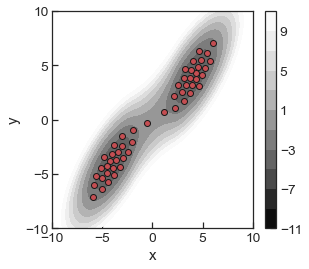

In [262]:
fig, ax = plt.subplots(figsize=(4.5,4))
lev = np.arange(-11,13, 2)
CS = ax.contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r')
ax.plot(ccx, ccy, linewidth=0, marker='o', mfc='r', mec='k')
#im = ax.imshow(mat, extent=[-10, 10, -10, 10], origin='lower',
#           cmap='viridis', alpha=0.5);
plt.colorbar(CS)
ax.set_xlabel('x')
ax.set_ylabel('y')
yt = np.arange(-10,10,5)
ax.set_yticks([-10,-5,0,5,10])

Construct the MSM corresponding to the aforementioned discretization.

In [263]:
import pyemma.msm as msm
import pyemma.plots as mplt
lags = [1, 2, 5, 10, 20, 30]

its = msm.its(dtrajs, lags=lags, errors='bayes')

estimating BayesianMSM:   0%|          | 0/6 [00:00<?, ?it/s]

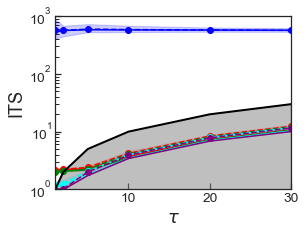

In [264]:
fig, ax = plt.subplots(figsize=(4.5,3.5))
mplt.plot_implied_timescales(its, ylog=True, nits=5)
ax.set_ylim(1,1000)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('ITS', fontsize=18)
plt.tight_layout()
plt.savefig('../figures/cossio/its_msm.png', dpi=300, transparent=True)

In [265]:
M = msm.estimate_markov_model(dtrajs, 10)

In [266]:
M.timescales()[:2]

array([581.16239273,   3.69933149])

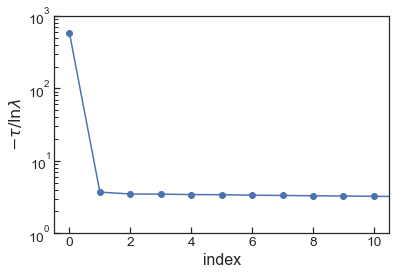

In [267]:
fig, ax = plt.subplots()
ax.plot(M.timescales(),linewidth=1.5, marker='o')
ax.set_xlabel(r'index', fontsize=16)
ax.set_ylabel(r'$-\tau/\ln \lambda$', fontsize=16)
ax.set_xlim(-0.5,10.5)
ax.set_ylim(1,1000)
plt.yscale('log')

Since there is a single slow process, let us lump the microstates into two macrostates by using PCCA+ spectral clustering.

In [268]:
M.pcca(2)

PCCA(P=array([[0.03988, 0.     , ..., 0.     , 0.     ],
       [0.     , 0.06684, ..., 0.0203 , 0.03143],
       ...,
       [0.     , 0.05875, ..., 0.02273, 0.03598],
       [0.     , 0.05975, ..., 0.02363, 0.04975]]),
   m=2)

In [269]:
pcca_sets = M.metastable_sets

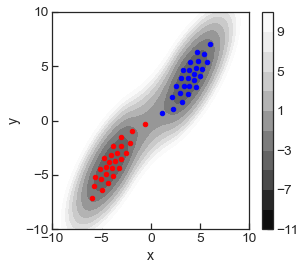

In [270]:
fig, ax = plt.subplots(figsize=(4.5, 4))
CS = ax.contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r')
#ax.imshow(mat, extent=[-10, 10, -10, 10], origin='lower',
#           cmap='viridis', alpha=0.5);#RdGy
ax.scatter(cl.clustercenters[pcca_sets[0],0], cl.clustercenters[pcca_sets[0],1], color='red', s=20)
ax.scatter(cl.clustercenters[pcca_sets[1],0], cl.clustercenters[pcca_sets[1],1], color='blue', s=20)
#im = ax.imshow(mat, extent=[-10, 10, -10, 10], origin='lower',
#           cmap='viridis', alpha=0.5);
plt.colorbar(CS)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/cossio/assign_msm.png', dpi=300, transparent=True)

Chapman-Kolmogorov test for the MSM resulting from PCCA+ clustering.

In [271]:
M = msm.bayesian_markov_model(dtrajs, 10)

pyemma.msm.estimators.bayesian_msm.BayesianMSM[89]: compute stat. inefficiencies:   0%|          | 0/1420 [00:…

pyemma.msm.estimators.bayesian_msm.BayesianMSM[89]: Sampling MSMs:   0%|          | 0/100 [00:00<?, ?it/s]

In [272]:
ck = M.cktest(2) #M.cktest(3)

estimating BayesianMSM:   0%|          | 0/9 [00:00<?, ?it/s]

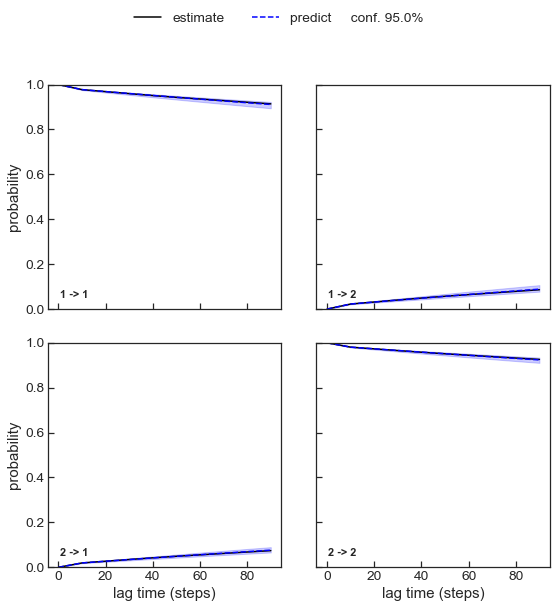

In [273]:
plt.rcParams.update({'font.size': 11})
fig, axes = mplt.plot_cktest(ck, figsize=(9, 9), padding_between=0.15, padding_top=0.13)

#mplt.plot_cktest(ck)

### MSM construction exploting density-based clustering

In [274]:
import hdbscan

In [275]:
data = np.vstack((X))

In [276]:
np.shape(data)

(25001, 2)

Apply HDBSCAN clustering with 'minimum cluster size' equal to 50 and 'minimum samples' equal to 70 to previously normalized data. Then look into resulting clusters.

In [277]:
from sklearn.preprocessing import StandardScaler
norm_X = StandardScaler().fit_transform(data)

In [278]:
hdb = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=70).fit(norm_X)

In [279]:
np.unique(hdb.labels_)

array([-1,  0,  1])

-1 cluster label denotes 'noise', so two clusters are obtained from HDBSCAN clustering. The latter can be better understood from the corresponding condensed tree plot. For more details see https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

<AxesSubplot:ylabel='$\\lambda$ value'>

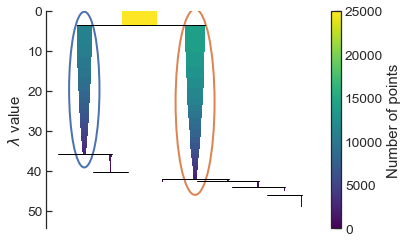

In [280]:
hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

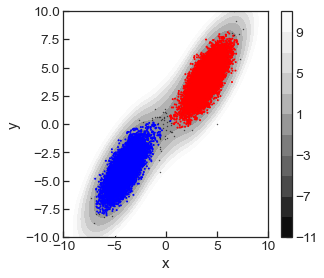

In [281]:
fig, ax = plt.subplots(figsize=(4.5, 4))
assign = hdb.labels_ >= 0
CS = ax.contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r')
ax.scatter(data[assign,0],data[assign,1], marker='o', 
                cmap='bwr', s=1, c=hdb.labels_[assign])
nassign = hdb.labels_ == -1
ax.scatter(data[nassign,0],data[nassign,1], marker='.', 
                s=0.5, c='k')
plt.colorbar(CS)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.tight_layout()

In order to be more stringent with the TBA methodology, let us set as 'noise' those points whose probability to be in their corresponding clusters is less than 40%.

In [282]:
for i, x_i in enumerate(hdb.labels_):
    if hdb.probabilities_[i] < 0.4:
        hdb.labels_[i] = -1
assign = hdb.labels_>= 0
nassign = hdb.labels_ < 0

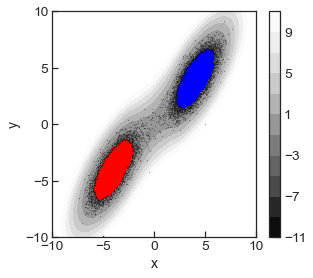

In [283]:
fig, ax = plt.subplots(figsize=(4.5,4))
# histogram data
CS = ax.contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r')
plt.colorbar(CS)

assign = hdb.labels_ >= 0
ax.scatter(data[assign,0],data[assign,1], marker='o', 
                cmap='bwr_r', s=1, c=hdb.labels_[assign])
nassign = hdb.labels_ == -1
ax.scatter(data[nassign,0],data[nassign,1], marker='.', 
                cmap='k', s=0.1, c='k')
ax.set_yticks(range(-10,11,5))
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/cossio/assign_hdb.png', dpi=300, transparent=True)

If we consider clusterization good enough, proceed to lag time selection and MSM estimation

In [284]:
import pyemma.msm as msm
import pyemma.plots as mplt
lags = [1, 2, 5, 10, 20, 30]

In [285]:
its_hdb = msm.its(hdb.labels_[assign], lags=lags, errors='bayes')

estimating BayesianMSM:   0%|          | 0/6 [00:00<?, ?it/s]

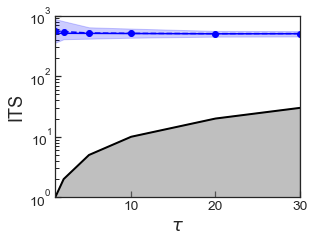

In [286]:
fig, ax = plt.subplots(figsize=(4.5,3.5))
mplt.plot_implied_timescales(its_hdb, ylog=True)
ax.set_ylim(1,1000)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('ITS', fontsize=18)
plt.tight_layout()
plt.savefig('../figures/cossio/its_hdb.png', dpi=300, transparent=True)

In [287]:
M_hdb = msm.estimate_markov_model(hdb.labels_[assign], 10)

In [288]:
M_hdb.timescales()

array([507.81713843])

Validate the obtained HDBSCAN MSM by carrying out the corresponding Chapman-Kolmogorov test.

In [289]:
M = msm.bayesian_markov_model(hdb.labels_[assign], 10)

pyemma.msm.estimators.bayesian_msm.BayesianMSM[95]: compute stat. inefficiencies:   0%|          | 0/4 [00:00<…

pyemma.msm.estimators.bayesian_msm.BayesianMSM[95]: Sampling MSMs:   0%|          | 0/100 [00:00<?, ?it/s]

In [290]:
ck = M.cktest(2)

estimating BayesianMSM:   0%|          | 0/9 [00:00<?, ?it/s]

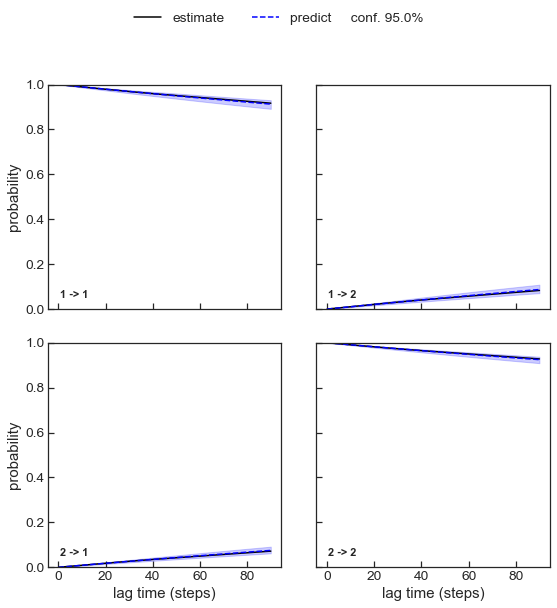

In [291]:
plt.rcParams.update({'font.size': 11})
fig, axes = mplt.plot_cktest(ck, figsize=(9, 9), padding_between=0.15, padding_top=0.13)